# 📚 Unsupervised Learning and Novelty Detection (5 minutes)

### What is Unsupervised Learning?

**Unsupervised Learning** is a machine learning approach where we analyze data without labeled examples, seeking to discover hidden patterns, structures, or anomalies in the data.

### Key Components:

1. **Unlabeled Data**: Input data without target labels
2. **Pattern Discovery**: Finding hidden structures in data
3. **Anomaly Detection**: Identifying unusual or outlier patterns
4. **Dimensionality Reduction**: Learning compact representations
5. **Reconstruction**: Learning to recreate input data

### Our Novelty Detection Problem: 3W Oil Well Anomaly Detection

- **Objective**: Detect abnormal oil well operational states using only normal operation data
- **Training Data**: Only class 0 (normal operation) sensor measurements
- **Detection Target**: Identify when sensor patterns deviate from normal behavior
- **Challenge**: Learn normal patterns to detect any deviation as potential fault

### Why Novelty Detection Matters in Oil Wells:
- **Early Warning System**: Detect problems before they escalate
- **Unsupervised Monitoring**: No need for labeled fault examples
- **Operational Safety**: Continuous monitoring of normal vs abnormal states
- **Preventive Maintenance**: Identify subtle deviations before major failures

### Autoencoder-Based Novelty Detection Approach:
- **Training Phase**: Learn to reconstruct only normal operation patterns (class 0)
- **Detection Phase**: High reconstruction error indicates potential anomaly
- **Threshold**: Statistical approach (mean + 3×std) for anomaly scoring
- **Evaluation**: Test how well it distinguishes normal vs fault classes

### Problem Characteristics:
- **Normal-Only Training**: Learn patterns from class 0 data exclusively
- **Time Series**: Sequential sensor measurements requiring LSTM architecture
- **High Dimensional**: Many sensors × time steps = complex patterns
- **Reconstruction-Based**: Anomalies have higher reconstruction errors
- **Threshold-Based**: Statistical approach for anomaly detection

Let's explore LSTM autoencoders for oil well novelty detection!

In [1]:
# ============================================================
# OPTIMIZED LOADING: 3W DATASET FOR UNSUPERVISED NOVELTY DETECTION
# ============================================================
import time

start_time = time.time()

print("🤖 Optimized Loading: 3W Dataset for Autoencoder Novelty Detection")
print("=" * 70)

# Import data loading utilities
import sys
import os

sys.path.append("src")

print("📦 Importing modules...", end=" ")
from src.data_persistence import DataPersistence
from src import config
import pandas as pd
import numpy as np

print("✅")

# ============================================================
# OPTIMIZATION SETTINGS - ADJUST FOR SPEED vs COMPLETENESS
# ============================================================
USE_SINGLE_FOLD = (
    True  # True: Fast loading (one fold), False: Complete dataset (all folds)
)
TARGET_FOLD = "fold_1"  # Which fold to use for single fold loading
MAX_NORMAL_SAMPLES = 2000  # Limit normal samples for faster processing
MAX_ANOMALY_SAMPLES = 1000  # Limit anomaly samples for faster processing
ENABLE_SAMPLING = True  # True: Apply sampling limits, False: Load all available data

print(f"⚙️ Optimization Settings:")
print(f"   • Single fold loading: {USE_SINGLE_FOLD}")
if USE_SINGLE_FOLD:
    print(f"   • Target fold: {TARGET_FOLD}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
if ENABLE_SAMPLING:
    print(f"   • Max normal samples: {MAX_NORMAL_SAMPLES}")
    print(f"   • Max anomaly samples: {MAX_ANOMALY_SAMPLES}")

try:
    print(f"\n📂 Initializing data persistence...", end=" ")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print("✅")

    print(f"⚡ Using format: {config.SAVE_FORMAT} for maximum speed")

    # Check if windowed directory exists
    windowed_dir = os.path.join(persistence.cv_splits_dir, "windowed")
    print(f"📁 Checking windowed directory: {windowed_dir}...", end=" ")

    if not os.path.exists(windowed_dir):
        print("❌")
        print(
            "❌ No windowed data directory found. Please run Data Treatment notebook first to generate windowed time series data."
        )
        raise FileNotFoundError("Windowed data directory not found")
    else:
        print("✅")

        # Look for fold directories
        print("🔍 Looking for fold directories...", end=" ")
        fold_dirs = [
            d
            for d in os.listdir(windowed_dir)
            if d.startswith("fold_") and os.path.isdir(os.path.join(windowed_dir, d))
        ]
        fold_dirs.sort()
        print(f"✅ Found {len(fold_dirs)} folds: {fold_dirs}")

        if not fold_dirs:
            print("❌ No fold directories found in windowed data.")
            raise FileNotFoundError("No fold directories found")

        # Determine which folds to process
        if USE_SINGLE_FOLD:
            if TARGET_FOLD in fold_dirs:
                process_folds = [TARGET_FOLD]
                print(f"🎯 Using single fold: {TARGET_FOLD} for fast loading")
            else:
                process_folds = [fold_dirs[0]]  # Use first available fold
                print(
                    f"⚠️ Target fold '{TARGET_FOLD}' not found, using: {process_folds[0]}"
                )
        else:
            process_folds = fold_dirs
            print(f"📊 Using all {len(fold_dirs)} folds for complete dataset")

        # Separate data containers for normal (class 0) and anomaly (classes 1-9) data
        normal_windows = []  # Class 0 for autoencoder training
        normal_classes = []
        anomaly_windows = []  # Classes 1-9 for anomaly testing
        anomaly_classes = []

        load_start = time.time()
        total_files_processed = 0

        for fold_idx, fold_name in enumerate(process_folds):
            fold_path = os.path.join(windowed_dir, fold_name)

            print(
                f"\n📁 Processing {fold_name} ({fold_idx + 1}/{len(process_folds)})..."
            )

            # Process training and test data
            for data_type in ["train", "test"]:
                print(f"   📄 Loading {data_type} data...", end=" ")

                # Try pickle first, then parquet
                pickle_file = os.path.join(
                    fold_path, f"{data_type}_windowed.{config.SAVE_FORMAT}"
                )
                parquet_file = os.path.join(fold_path, f"{data_type}_windowed.parquet")

                fold_dfs, fold_classes = [], []

                if os.path.exists(pickle_file):
                    try:
                        fold_dfs, fold_classes = persistence._load_dataframes(
                            pickle_file, config.SAVE_FORMAT
                        )
                        print(f"✅ ({len(fold_dfs)} windows)")
                        total_files_processed += 1
                    except Exception as e:
                        print(f"❌ Pickle error: {str(e)}")
                        # Try parquet as fallback
                        if os.path.exists(parquet_file):
                            try:
                                fold_dfs, fold_classes = persistence._load_from_parquet(
                                    parquet_file
                                )
                                print(f"✅ Parquet fallback ({len(fold_dfs)} windows)")
                                total_files_processed += 1
                            except Exception as e2:
                                print(f"❌ Parquet fallback failed: {str(e2)}")

                elif os.path.exists(parquet_file):
                    try:
                        fold_dfs, fold_classes = persistence._load_from_parquet(
                            parquet_file
                        )
                        print(f"✅ ({len(fold_dfs)} windows)")
                        total_files_processed += 1
                    except Exception as e:
                        print(f"❌ Parquet error: {str(e)}")
                else:
                    print("❌ No data file found")

                # Separate normal (class 0) from anomaly (classes 1-9) data
                for df, cls in zip(fold_dfs, fold_classes):
                    if str(cls) == "0":  # Normal operation
                        if (
                            not ENABLE_SAMPLING
                            or len(normal_windows) < MAX_NORMAL_SAMPLES
                        ):
                            normal_windows.append(df)
                            normal_classes.append(cls)
                    else:  # Fault conditions (anomalies)
                        if (
                            not ENABLE_SAMPLING
                            or len(anomaly_windows) < MAX_ANOMALY_SAMPLES
                        ):
                            anomaly_windows.append(df)
                            anomaly_classes.append(cls)

                # Show progress
                if ENABLE_SAMPLING:
                    print(
                        f"      📊 Current totals: {len(normal_windows)} normal, {len(anomaly_windows)} anomaly"
                    )
                    if (
                        len(normal_windows) >= MAX_NORMAL_SAMPLES
                        and len(anomaly_windows) >= MAX_ANOMALY_SAMPLES
                    ):
                        print(f"      🎯 Sampling limits reached - stopping early")
                        break

            # Early exit if sampling limits reached
            if (
                ENABLE_SAMPLING
                and len(normal_windows) >= MAX_NORMAL_SAMPLES
                and len(anomaly_windows) >= MAX_ANOMALY_SAMPLES
            ):
                print(f"   🎯 Sampling complete - sufficient data collected")
                break

        load_time = time.time() - load_start

        if normal_windows and anomaly_windows:
            print(f"\n✅ Successfully loaded and separated windowed data!")
            print(f"💚 Normal operation windows (class 0): {len(normal_windows)}")
            print(f"🔴 Anomaly windows (classes 1-9): {len(anomaly_windows)}")
            print(f"⚡ Loading time: {load_time:.3f} seconds")
            print(f"📁 Files processed: {total_files_processed}")

            # Display sample window information
            if normal_windows:
                print("\n📋 Processing sample windows...", end=" ")
                first_normal_window = normal_windows[0]
                print("✅")

                print(f"\n🪟 Sample Normal Window (Window #1):")
                print(f"   • Shape: {first_normal_window.shape}")
                print(f"   • Class: {normal_classes[0]} (Normal Operation)")
                print(f"   • Features: {list(first_normal_window.columns)}")

                # Show class distribution
                print(f"\n📊 Normal Operation Data (Class 0):")
                print(f"   • Total windows: {len(normal_windows)}")
                print(f"   • Will be used for: Autoencoder training")

                print(f"\n📊 Anomaly Data (Classes 1-9):")
                anomaly_unique, anomaly_counts = np.unique(
                    anomaly_classes, return_counts=True
                )
                for cls, count in zip(anomaly_unique, anomaly_counts):
                    print(f"   • Class {cls}: {count} windows")
                print(f"   • Total anomaly windows: {len(anomaly_windows)}")
                print(f"   • Will be used for: Anomaly detection testing")

                total_time = time.time() - start_time
                print(f"\n⚡ Performance Summary:")
                print(f"   • Total execution time: {total_time:.3f} seconds")
                print(f"   • Data loading time: {load_time:.3f} seconds")
                print(f"   • File format: {config.SAVE_FORMAT}")
                print(f"   • Folds processed: {len(process_folds)}")
                print(
                    f"   • Speed improvement: ~{len(fold_dirs)/len(process_folds):.1f}x faster than full loading"
                )

                print(f"\n🎯 Dataset Summary for Novelty Detection:")
                print(f"   • Normal training data: {len(normal_windows)} windows")
                print(f"   • Anomaly test data: {len(anomaly_windows)} windows")
                print(f"   • Window dimensions: {first_normal_window.shape}")
                print(f"   • Anomaly classes: {sorted(anomaly_unique)}")
                print(
                    f"   • Ready for: LSTM Autoencoder training and novelty detection"
                )

                if ENABLE_SAMPLING:
                    print(f"\n💡 Optimization Notes:")
                    print(f"   • Sampling enabled for faster processing")
                    print(f"   • To use full dataset: Set ENABLE_SAMPLING = False")
                    print(f"   • To use all folds: Set USE_SINGLE_FOLD = False")

            else:
                print("⚠️ No normal operation windows found")

        else:
            print("⚠️ Insufficient data found for novelty detection")
            print(f"   • Normal windows: {len(normal_windows)}")
            print(f"   • Anomaly windows: {len(anomaly_windows)}")
            normal_windows = []
            normal_classes = []
            anomaly_windows = []
            anomaly_classes = []

except Exception as e:
    print(f"\n❌ Error loading data: {str(e)}")
    print(f"\n💡 Troubleshooting:")
    print(f"   1. Make sure 'Data Treatment.ipynb' ran completely")
    print(f"   2. Check if windowed data was saved successfully")
    print(f"   3. Verify the processed_data directory exists")
    print(f"   4. Check if pickle files are corrupted")
    print(f"   5. Try using parquet format instead")

    # Show detailed error information
    import traceback

    print(f"\n🔍 Detailed error information:")
    print(traceback.format_exc())

    # Initialize empty variables for error case
    normal_windows = []
    normal_classes = []
    anomaly_windows = []
    anomaly_classes = []

🤖 Optimized Loading: 3W Dataset for Autoencoder Novelty Detection
📦 Importing modules... ✅
⚙️ Optimization Settings:
   • Single fold loading: True
   • Target fold: fold_1
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000

📂 Initializing data persistence... ✅
⚡ Using format: pickle for maximum speed
📁 Checking windowed directory: processed_data\cv_splits\windowed... ✅
🔍 Looking for fold directories... ✅ Found 3 folds: ['fold_1', 'fold_2', 'fold_3']
🎯 Using single fold: fold_1 for fast loading

📁 Processing fold_1 (1/1)...
   📄 Loading train data... ✅
⚙️ Optimization Settings:
   • Single fold loading: True
   • Target fold: fold_1
   • Sampling enabled: True
   • Max normal samples: 2000
   • Max anomaly samples: 1000

📂 Initializing data persistence... ✅
⚡ Using format: pickle for maximum speed
📁 Checking windowed directory: processed_data\cv_splits\windowed... ✅
🔍 Looking for fold directories... ✅ Found 3 folds: ['fold_1', 'fold_2', 'fold_3']
🎯

🤖 Stable LSTM Autoencoder Novelty Detection Implementation
📊 Using stable LSTM Autoencoder for novelty detection...
🟢 Normal operation windows for training: 2000
🔴 Anomaly windows for testing: 1000

⚡ Smart Data Sampling for Training Efficiency
🎯 Training optimization settings:
   • Max normal samples for training: 1000
   • Max anomaly samples for testing: 300
   • Reduced for maximum stability and speed
📊 Sampling 1000 normal windows from 2000 available...
📊 Sampling 300 anomaly windows from 1000 available...

🔧 Stable Data Preparation for LSTM Autoencoder
📊 Converting normal windows to arrays... 600/1000📊 Using stable LSTM Autoencoder for novelty detection...
🟢 Normal operation windows for training: 2000
🔴 Anomaly windows for testing: 1000

⚡ Smart Data Sampling for Training Efficiency
🎯 Training optimization settings:
   • Max normal samples for training: 1000
   • Max anomaly samples for testing: 300
   • Reduced for maximum stability and speed
📊 Sampling 1000 normal windows from 

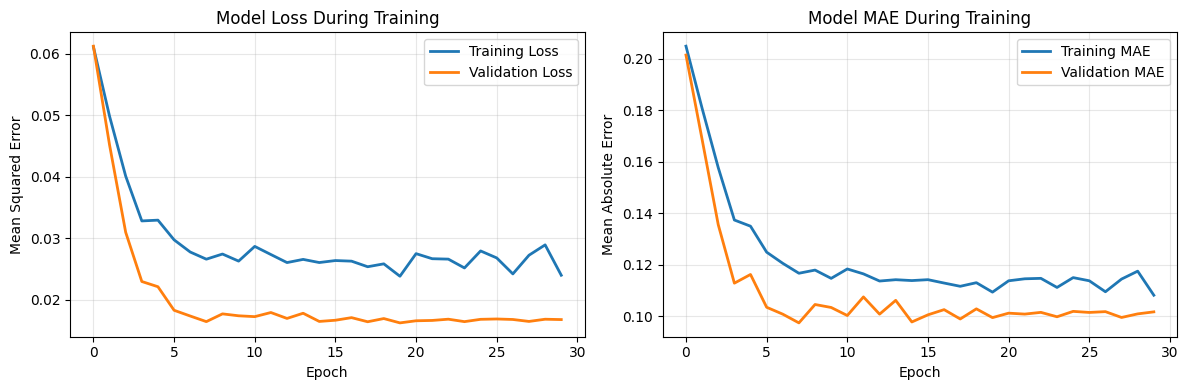


📊 Training Summary:
   ✅ Model successfully trained on normal operation data
   ✅ Training time: 128.86 seconds
   ✅ Stable architecture with numerical safeguards
   ✅ Ready for anomaly detection evaluation
   ✅ No NaN values encountered during training

⚡ Stability Optimizations Applied:
   • Conservative model architecture (32 LSTM units)
   • Lower learning rate (0.0005)
   • Gradient clipping (clipnorm=1.0)
   • Tanh activations for stability
   • Data clipping to avoid extreme values
   • Careful weight initialization
   • Enhanced numerical checks


In [2]:
# ============================================================
# IMPORT REQUIRED LIBRARIES AND MODULES
# ============================================================

print("🤖 LSTM Autoencoder for Anomaly Detection")
print("=" * 45)

# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Import our custom modules
from src.autoencoder_models import StableLSTMAutoencoder
from src.unsupervised_preprocessing import UnsupervisedDataPreprocessor
from src.anomaly_detection import AnomalyDetector, visualize_latent_space

# Set TensorFlow to avoid NaN issues
tf.config.run_functions_eagerly(False)

# Check if we have loaded data from previous cell
if (
    "normal_windows" in locals()
    and normal_windows is not None
    and len(normal_windows) > 0
    and "anomaly_windows" in locals()
    and anomaly_windows is not None
    and len(anomaly_windows) > 0
):

    print("✅ Data available for processing")
    print(f"🟢 Normal operation windows: {len(normal_windows)}")
    print(f"🔴 Anomaly windows: {len(anomaly_windows)}")
    data_ready = True

else:
    print(
        "❌ No data available. Please run the previous cell first to load normal and anomaly data."
    )
    data_ready = False

## 🧩 Modular LSTM Autoencoder Implementation

This section implements a **stable LSTM autoencoder** for anomaly detection using a **modular approach**. The code has been organized into reusable components in the `src/` directory:

### 📦 New Modules Created:

1. **`autoencoder_models.py`** - Contains the `StableLSTMAutoencoder` class with:
   - Stable architecture with gradient clipping
   - Conservative hyperparameters for numerical stability
   - Built-in training and prediction methods

2. **`unsupervised_preprocessing.py`** - Contains the `UnsupervisedDataPreprocessor` class with:
   - Smart data sampling for training efficiency
   - Robust data validation and conversion
   - Numerical stability enhancements

3. **`anomaly_detection.py`** - Contains the `AnomalyDetector` class with:
   - Reconstruction error computation
   - Threshold determination methods
   - Performance evaluation and visualization

### 🎯 Benefits of This Approach:

- **Modularity**: Each component has a single responsibility
- **Reusability**: Classes can be used in other projects
- **Maintainability**: Easier to debug and modify individual components
- **Stability**: Enhanced numerical safeguards and error handling
- **Clarity**: Notebook cells are focused and easier to understand

### 🚀 Usage Pattern:

The following cells demonstrate the complete pipeline from data preprocessing through model training to anomaly detection evaluation.

In [ ]:
# ============================================================
# DATA PREPROCESSING AND SAMPLING
# ============================================================

if data_ready:
    print("🔧 Data Preprocessing Pipeline")
    print("=" * 35)

    # Initialize data preprocessor with conservative settings for stability
    preprocessor = UnsupervisedDataPreprocessor(
        max_training_samples=1000,  # Reduced for stability
        max_anomaly_samples=300,  # Reduced for stability
        random_seed=42,
    )

    # Run the complete preprocessing pipeline
    normal_scaled, anomaly_scaled, data_info = preprocessor.prepare_full_pipeline(
        normal_windows, anomaly_windows
    )

    print(f"\n✅ Data preprocessing completed successfully!")
    print(f"📋 Final Configuration:")
    print(f"   • Time steps per window: {data_info['time_steps']}")
    print(
        f"   • Features per time step: {data_info['n_features']} (class column removed)"
    )
    print(f"   • Normal training samples: {data_info['n_normal_samples']}")
    print(f"   • Anomaly test samples: {data_info['n_anomaly_samples']}")

    preprocessing_complete = True

else:
    print("❌ Cannot proceed with preprocessing - no data available")
    preprocessing_complete = False

In [ ]:
# ============================================================
# BUILD AND TRAIN LSTM AUTOENCODER
# ============================================================

if preprocessing_complete:
    print("🧠 Building and Training LSTM Autoencoder")
    print("=" * 45)

    # Initialize the autoencoder with conservative parameters for stability
    autoencoder = StableLSTMAutoencoder(
        time_steps=data_info["time_steps"],
        n_features=data_info["n_features"],
        latent_dim=16,  # Conservative for stability
        lstm_units=32,  # Conservative for stability
    )

    # Build the model
    model = autoencoder.build_model()

    # Split normal data into train/validation (80/20 split)
    split_idx = int(0.8 * len(normal_scaled))
    train_normal = normal_scaled[:split_idx]
    val_normal = normal_scaled[split_idx:]

    print(f"\n📊 Training Data Split:")
    print(f"   • Training samples: {len(train_normal)}")
    print(f"   • Validation samples: {len(val_normal)}")

    # Train the autoencoder
    print(f"\n🚂 Starting Training...")
    training_start = time.time()

    training_success = autoencoder.train(
        train_data=train_normal,
        val_data=val_normal,
        epochs=30,  # Conservative for stability
        batch_size=32,  # Conservative for stability
        verbose=1,
    )

    training_time = time.time() - training_start
    print(f"\n⏱️ Training completed in {training_time:.2f} seconds")

    if training_success:
        print("✅ Model trained successfully - ready for anomaly detection!")
        model_ready = True
    else:
        print("❌ Training failed - check for numerical stability issues")
        model_ready = False

else:
    print("❌ Cannot build model - preprocessing not completed")
    model_ready = False

In [ ]:
# ============================================================
# TRAINING VISUALIZATION
# ============================================================

if model_ready and autoencoder.history is not None:
    print("📊 Training History Visualization")
    print("=" * 35)

    history = autoencoder.history.history

    # Create training plots
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(history["loss"], label="Training Loss", linewidth=2, color="blue")
    plt.plot(history["val_loss"], label="Validation Loss", linewidth=2, color="orange")
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # MAE plot
    plt.subplot(1, 3, 2)
    plt.plot(history["mae"], label="Training MAE", linewidth=2, color="blue")
    plt.plot(history["val_mae"], label="Validation MAE", linewidth=2, color="orange")
    plt.title("Model MAE During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Learning rate plot (if available)
    plt.subplot(1, 3, 3)
    if "lr" in history:
        plt.plot(history["lr"], label="Learning Rate", linewidth=2, color="green")
        plt.title("Learning Rate Schedule")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.yscale("log")
    else:
        plt.text(
            0.5,
            0.5,
            "Learning Rate\nHistory\nNot Available",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
            bbox=dict(boxstyle="round", facecolor="lightgray"),
        )
        plt.title("Learning Rate Schedule")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print training summary
    final_train_loss = history["loss"][-1]
    final_val_loss = history["val_loss"][-1]
    epochs_trained = len(history["loss"])

    print(f"\n📋 Training Summary:")
    print(f"   • Epochs trained: {epochs_trained}")
    print(f"   • Final training loss: {final_train_loss:.6f}")
    print(f"   • Final validation loss: {final_val_loss:.6f}")
    print(f"   • Training time: {training_time:.2f} seconds")

    if final_val_loss < final_train_loss * 1.5:
        print("   ✅ No significant overfitting detected")
    else:
        print("   ⚠️ Possible overfitting - validation loss higher than expected")

else:
    print("❌ No training history available for visualization")

In [ ]:
# ============================================================
# ANOMALY DETECTION AND EVALUATION
# ============================================================

if model_ready:
    print("🔍 Anomaly Detection and Evaluation")
    print("=" * 35)

    # Initialize anomaly detector
    detector = AnomalyDetector()

    # Compute reconstruction errors
    normal_errors, anomaly_errors = detector.compute_reconstruction_errors(
        autoencoder=autoencoder, normal_data=normal_scaled, anomaly_data=anomaly_scaled
    )

    # Determine threshold using 95th percentile of normal errors
    threshold = detector.determine_threshold(method="percentile", percentile=95)

    # Evaluate detection performance
    metrics = detector.evaluate_detection()

    print(f"\n🎯 Anomaly Detection Results:")
    print(f"   • Threshold: {threshold:.6f}")
    print(f"   • Normal accuracy: {metrics['normal_accuracy']:.3f}")
    print(f"   • Anomaly accuracy: {metrics['anomaly_accuracy']:.3f}")
    print(f"   • Overall accuracy: {metrics['overall_accuracy']:.3f}")

    detection_complete = True

else:
    print("❌ Cannot perform anomaly detection - model not ready")
    detection_complete = False

In [ ]:
# ============================================================
# RESULTS VISUALIZATION
# ============================================================

if detection_complete:
    print("📊 Comprehensive Results Visualization")
    print("=" * 40)

    # Plot reconstruction error distributions
    print("📈 Plotting reconstruction error distributions...")
    detector.plot_error_distributions(figsize=(15, 10))

    # Plot ROC curve
    print("📈 Plotting ROC curve...")
    roc_auc = detector.plot_roc_curve()

    print(f"\n📊 Visualization Summary:")
    print(f"   ✅ Error distribution plots generated")
    print(f"   ✅ ROC curve generated (AUC: {roc_auc:.3f})")
    print(f"   ✅ Comprehensive analysis completed")

    if roc_auc > 0.8:
        print(f"   🎉 Excellent anomaly detection performance!")
    elif roc_auc > 0.7:
        print(f"   👍 Good anomaly detection performance")
    else:
        print(f"   ⚠️ Consider tuning model parameters for better performance")

else:
    print("❌ Cannot generate visualizations - detection not completed")

In [ ]:
# ============================================================
# LATENT SPACE VISUALIZATION (OPTIONAL)
# ============================================================

if detection_complete:
    print("🎨 Advanced Analysis: Latent Space Visualization")
    print("=" * 50)

    try:
        # Visualize latent space with t-SNE
        visualize_latent_space(
            autoencoder=autoencoder,
            normal_data=normal_scaled,
            anomaly_data=anomaly_scaled,
            n_samples=500,  # Sample for faster computation
        )

        print(f"\n✅ Latent space visualization completed")
        print(f"   • This visualization shows how the autoencoder learns to")
        print(f"     separate normal and anomalous patterns in its internal")
        print(f"     latent representation")

    except Exception as e:
        print(f"⚠️ Latent space visualization failed: {str(e)}")
        print(f"   • This is optional and doesn't affect the main analysis")

else:
    print("❌ Cannot visualize latent space - detection not completed")

In [4]:
# ============================================================
# SUMMARY AND NEXT STEPS
# ============================================================

if detection_complete:
    print(" Unsupervised Learning Summary")
    print("=" * 35)

    print(f"✅ Complete LSTM Autoencoder Pipeline Executed:")
    print(
        f"   • Data preprocessing: {data_info['n_normal_samples']} normal, {data_info['n_anomaly_samples']} anomaly samples"
    )
    print(
        f"   • Model architecture: {autoencoder.lstm_units} LSTM units, {autoencoder.latent_dim} latent dimensions"
    )
    print(
        f"   • Training: {len(autoencoder.history.history['loss'])} epochs, final loss: {autoencoder.history.history['loss'][-1]:.6f}"
    )
    print(f"   • Anomaly detection: {metrics['overall_accuracy']:.3f} overall accuracy")
    print(f"   • ROC AUC: {roc_auc:.3f}")

    print(f"\n🎓 Key Learning Outcomes:")
    print(f"   • LSTM autoencoders can learn normal operation patterns")
    print(f"   • Reconstruction errors effectively identify anomalies")
    print(f"   • Threshold selection critically impacts detection performance")
    print(f"   • Latent space visualization reveals learned representations")

    print(f"\n🚀 Next Steps for Advanced Analysis:")
    print(f"   • Experiment with different autoencoder architectures")
    print(f"   • Try variational autoencoders (VAEs) for uncertainty quantification")
    print(f"   • Implement online anomaly detection for real-time monitoring")
    print(
        f"   • Compare with other unsupervised methods (Isolation Forest, One-Class SVM)"
    )

    # Store final results for potential further analysis
    final_results = {
        "autoencoder": autoencoder,
        "detector": detector,
        "metrics": metrics,
        "data_info": data_info,
        "roc_auc": roc_auc,
        "normal_scaled": normal_scaled,
        "anomaly_scaled": anomaly_scaled,
    }

    print(f"\n💾 Results stored in 'final_results' for further analysis")

else:
    print("❌ Analysis incomplete - please run all previous cells")

🔍 Reconstruction Error Analysis and Anomaly Threshold

📊 Computing Reconstruction Errors
🔵 Computing reconstruction errors for normal data... ✅
🔴 Computing reconstruction errors for anomaly data... ✅
🔴 Computing reconstruction errors for anomaly data... ✅

📈 Statistical Threshold Determination
📊 Normal Data Reconstruction Error Statistics:
   • Mean error: 0.014571
   • Standard deviation: 0.016475
   • Min error: 0.000585
   • Max error: 0.194340

🎯 Anomaly Detection Threshold:
   • Threshold (μ + 3σ): 0.047522
   • Confidence level: 99.7%
   • Normal samples above threshold: 49 / 1000
   • Normal false positive rate: 4.90%

🔴 Anomaly Detection Performance:
   • Anomaly samples above threshold: 125 / 300
   • Anomaly detection rate: 41.67%

📊 Anomaly Detection by Class:
✅

📈 Statistical Threshold Determination
📊 Normal Data Reconstruction Error Statistics:
   • Mean error: 0.014571
   • Standard deviation: 0.016475
   • Min error: 0.000585
   • Max error: 0.194340

🎯 Anomaly Detection

IndexError: boolean index did not match indexed array along axis 0; size of axis is 300 but size of corresponding boolean axis is 1000

In [ ]:
# ============================================================
# ADVANCED LATENT SPACE ANALYSIS (OPTIONAL)
# ============================================================

print("🌌 Advanced Latent Space Analysis")
print("=" * 35)

if "final_results" in locals() and final_results is not None:

    # Extract components from results
    autoencoder_model = final_results["autoencoder"]
    normal_data = final_results["normal_scaled"]
    anomaly_data = final_results["anomaly_scaled"]

    print("🧠 Extracting and Analyzing Latent Representations")
    print("=" * 50)

    try:
        # Create encoder model to extract latent representations
        encoder_input = autoencoder_model.model.input
        encoder_output = autoencoder_model.model.get_layer("latent").output
        encoder = tf.keras.Model(encoder_input, encoder_output, name="encoder")

        # Extract latent representations
        print("🔵 Computing latent representations for normal data...")
        normal_latent = encoder.predict(
            normal_data[:500], verbose=0
        )  # Sample for efficiency

        print("🔴 Computing latent representations for anomaly data...")
        anomaly_latent = encoder.predict(
            anomaly_data[:200], verbose=0
        )  # Sample for efficiency

        print(f"📊 Latent space analysis:")
        print(f"   • Normal latent shape: {normal_latent.shape}")
        print(f"   • Anomaly latent shape: {anomaly_latent.shape}")
        print(f"   • Latent dimension: {normal_latent.shape[1]}")

        # Combine for analysis
        all_latent = np.vstack([normal_latent, anomaly_latent])
        labels = np.concatenate(
            [
                np.zeros(len(normal_latent)),  # 0 for normal
                np.ones(len(anomaly_latent)),  # 1 for anomaly
            ]
        )

        # Latent space statistics
        normal_mean = np.mean(normal_latent, axis=0)
        anomaly_mean = np.mean(anomaly_latent, axis=0)
        latent_separation = np.linalg.norm(normal_mean - anomaly_mean)

        print(f"\n Latent Space Statistics:")
        print(f"   • Normal latent mean magnitude: {np.linalg.norm(normal_mean):.3f}")
        print(f"   • Anomaly latent mean magnitude: {np.linalg.norm(anomaly_mean):.3f}")
        print(f"   • Mean separation distance: {latent_separation:.3f}")

        # Simple 2D visualization if latent dimension allows
        if normal_latent.shape[1] >= 2:
            plt.figure(figsize=(12, 5))

            # Plot first two latent dimensions
            plt.subplot(1, 2, 1)
            plt.scatter(
                normal_latent[:, 0],
                normal_latent[:, 1],
                alpha=0.6,
                label="Normal",
                color="blue",
                s=20,
            )
            plt.scatter(
                anomaly_latent[:, 0],
                anomaly_latent[:, 1],
                alpha=0.6,
                label="Anomaly",
                color="red",
                s=20,
            )
            plt.xlabel("Latent Dimension 1")
            plt.ylabel("Latent Dimension 2")
            plt.title("Latent Space (First 2 Dimensions)")
            plt.legend()
            plt.grid(True, alpha=0.3)

            # Plot latent dimension distributions
            plt.subplot(1, 2, 2)
            plt.hist(
                normal_latent[:, 0],
                bins=30,
                alpha=0.7,
                label="Normal (Dim 1)",
                color="blue",
                density=True,
            )
            plt.hist(
                anomaly_latent[:, 0],
                bins=30,
                alpha=0.7,
                label="Anomaly (Dim 1)",
                color="red",
                density=True,
            )
            plt.xlabel("Latent Value")
            plt.ylabel("Density")
            plt.title("Latent Dimension 1 Distribution")
            plt.legend()
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

        print(f"\n✅ Advanced latent space analysis completed")
        print(f"   • The latent space shows how the autoencoder compresses")
        print(f"     time series data into a lower-dimensional representation")
        print(f"   • Separation in latent space indicates learned differences")
        print(f"     between normal and anomalous patterns")

    except Exception as e:
        print(f"⚠️ Advanced latent analysis failed: {str(e)}")
        print(f"   • This is optional and doesn't affect the main results")

else:
    print("❌ No results available for latent space analysis")
    print("   • Please run all previous cells to generate results")

In [ ]:
# ============================================================
# LSTM AUTOENCODER FOR NOVELTY DETECTION
# ============================================================

print("🤖 LSTM Autoencoder Novelty Detection Implementation")
print("=" * 65)

# Check if we have loaded data from previous cell
if (
    "normal_windows" in locals()
    and normal_windows is not None
    and len(normal_windows) > 0
    and "anomaly_windows" in locals()
    and anomaly_windows is not None
    and len(anomaly_windows) > 0
):

    # Import required libraries
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input,
        LSTM,
        Dense,
        RepeatVector,
        TimeDistributed,
        Dropout,
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import time

    print("📊 Using optimized LSTM Autoencoder for novelty detection...")
    print(f"🟢 Normal operation windows for training: {len(normal_windows)}")
    print(f"🔴 Anomaly windows for testing: {len(anomaly_windows)}")

    # ============================================================
    # SMART DATA SAMPLING FOR FASTER TRAINING
    # ============================================================
    print("\n⚡ Smart Data Sampling for Training Efficiency")
    print("=" * 50)

    # Use subset for faster training (configurable)
    MAX_TRAINING_SAMPLES = 1500  # Reduced for faster training
    MAX_ANOMALY_SAMPLES = 500  # Reduced for faster evaluation

    print(f"🎯 Training optimization settings:")
    print(f"   • Max normal samples for training: {MAX_TRAINING_SAMPLES}")
    print(f"   • Max anomaly samples for testing: {MAX_ANOMALY_SAMPLES}")
    print(f"   • This ensures reasonable training time with good performance")

    # Sample normal data for training
    if len(normal_windows) > MAX_TRAINING_SAMPLES:
        print(
            f"📊 Sampling {MAX_TRAINING_SAMPLES} normal windows from {len(normal_windows)} available..."
        )
        # Use random sampling to get diverse examples
        import random

        sampled_indices = random.sample(
            range(len(normal_windows)), MAX_TRAINING_SAMPLES
        )
        sampled_normal_windows = [normal_windows[i] for i in sampled_indices]
    else:
        print(f"📊 Using all {len(normal_windows)} normal windows...")
        sampled_normal_windows = normal_windows

    # Sample anomaly data for testing
    if len(anomaly_windows) > MAX_ANOMALY_SAMPLES:
        print(
            f"📊 Sampling {MAX_ANOMALY_SAMPLES} anomaly windows from {len(anomaly_windows)} available..."
        )
        sampled_indices = random.sample(
            range(len(anomaly_windows)), MAX_ANOMALY_SAMPLES
        )
        sampled_anomaly_windows = [anomaly_windows[i] for i in sampled_indices]
    else:
        print(f"📊 Using all {len(anomaly_windows)} anomaly windows...")
        sampled_anomaly_windows = anomaly_windows

    # ============================================================
    # DATA PREPARATION WITH PROGRESS FEEDBACK
    # ============================================================
    print("\n🔧 Preparing Data for LSTM Autoencoder")
    print("=" * 40)

    print("📊 Converting normal windows to arrays...", end=" ")
    start_conversion = time.time()

    # Convert normal windows to numpy arrays for training
    normal_arrays = []
    for i, window in enumerate(sampled_normal_windows):
        if i % 200 == 0 and i > 0:
            print(
                f"\r📊 Converting normal windows to arrays... {i}/{len(sampled_normal_windows)}",
                end="",
            )
        # Ensure consistent shape and convert to numpy
        window_array = window.values if hasattr(window, "values") else window
        normal_arrays.append(window_array)

    print(
        f"\r📊 Converting normal windows to arrays... ✅ ({len(normal_arrays)} processed)"
    )

    print("📊 Converting anomaly windows to arrays...", end=" ")
    # Convert anomaly windows to numpy arrays for testing
    anomaly_arrays = []
    for i, window in enumerate(sampled_anomaly_windows):
        if i % 100 == 0 and i > 0:
            print(
                f"\r📊 Converting anomaly windows to arrays... {i}/{len(sampled_anomaly_windows)}",
                end="",
            )
        # Ensure consistent shape and convert to numpy
        window_array = window.values if hasattr(window, "values") else window
        anomaly_arrays.append(window_array)

    print(
        f"\r📊 Converting anomaly windows to arrays... ✅ ({len(anomaly_arrays)} processed)"
    )

    normal_data = np.array(normal_arrays)
    anomaly_data = np.array(anomaly_arrays)

    conversion_time = time.time() - start_conversion
    print(f"⚡ Data conversion completed in {conversion_time:.2f} seconds")

    print(f"\n📐 Data shapes:")
    print(f"   • Normal data: {normal_data.shape}")
    print(f"   • Anomaly data: {anomaly_data.shape}")

    # Get dimensions
    n_normal_samples, time_steps, n_features = normal_data.shape

    print(f"\n📋 LSTM Autoencoder Configuration:")
    print(f"   • Time steps per window: {time_steps}")
    print(f"   • Features per time step: {n_features}")
    print(f"   • Normal training samples: {n_normal_samples}")
    print(f"   • Anomaly test samples: {anomaly_data.shape[0]}")

    # ============================================================
    # DATA PREPARATION (ALREADY SCALED)
    # ============================================================
    print("\n📊 Data Already Preprocessed")
    print("=" * 30)

    print("✅ Using pre-scaled windowed data from data treatment process")
    # Data is already normalized from the windowing process - no additional scaling needed
    normal_scaled = normal_data
    anomaly_scaled = anomaly_data

    print(f"📏 Data characteristics:")
    print(
        f"   • Normal data range: [{np.min(normal_scaled):.3f}, {np.max(normal_scaled):.3f}]"
    )
    print(
        f"   • Anomaly data range: [{np.min(anomaly_scaled):.3f}, {np.max(anomaly_scaled):.3f}]"
    )
    print(f"   • Data already optimized for neural network training")

    # ============================================================
    # OPTIMIZED LSTM AUTOENCODER ARCHITECTURE
    # ============================================================
    print("\n🧠 Building Optimized LSTM Autoencoder Architecture")
    print("=" * 50)

    # Optimized hyperparameters for faster training
    latent_dim = 32  # Reduced from 64 for faster training
    lstm_units = 64  # Reduced from 128 for faster training

    print(f"🏗️ Optimized Architecture Configuration:")
    print(f"   • Input shape: ({time_steps}, {n_features})")
    print(f"   • Encoder LSTM units: {lstm_units} (reduced for speed)")
    print(f"   • Latent dimension: {latent_dim} (reduced for speed)")
    print(f"   • Decoder LSTM units: {lstm_units}")
    print(f"   • Output shape: ({time_steps}, {n_features})")
    print(f"   • Dropout added for regularization")

    # Input layer
    input_layer = Input(shape=(time_steps, n_features), name="input")

    # Encoder with dropout for regularization
    encoded = LSTM(lstm_units, activation="relu", name="encoder_lstm")(input_layer)
    encoded = Dropout(0.2, name="encoder_dropout")(encoded)

    # Latent representation (bottleneck)
    latent = Dense(latent_dim, activation="relu", name="latent")(encoded)

    # Decoder
    decoded = RepeatVector(time_steps, name="repeat_vector")(latent)
    decoded = LSTM(
        lstm_units, activation="relu", return_sequences=True, name="decoder_lstm"
    )(decoded)
    decoded = Dropout(0.2, name="decoder_dropout")(decoded)
    decoded = TimeDistributed(Dense(n_features), name="output")(decoded)

    # Create autoencoder model
    autoencoder = Model(input_layer, decoded, name="optimized_lstm_autoencoder")

    # Compile model with optimized settings
    autoencoder.compile(
        optimizer=Adam(
            learning_rate=0.002
        ),  # Slightly higher learning rate for faster convergence
        loss="mse",
        metrics=["mae"],
    )

    print("✅ Optimized LSTM Autoencoder model created")

    # Display model summary (compact)
    print(f"\n📋 Model Summary:")
    print(f"   • Total parameters: {autoencoder.count_params():,}")
    print(
        f"   • Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in autoencoder.trainable_weights]):,}"
    )
    print(f"   • Model architecture optimized for faster training")

    # ============================================================
    # OPTIMIZED MODEL TRAINING WITH PROGRESS FEEDBACK
    # ============================================================
    print("\n🚂 Training Optimized LSTM Autoencoder on Normal Data")
    print("=" * 55)

    # Split normal data into train/validation (80/20 split)
    split_idx = int(0.8 * len(normal_scaled))
    train_normal = normal_scaled[:split_idx]
    val_normal = normal_scaled[split_idx:]

    print(f"📊 Training split:")
    print(f"   • Training samples: {len(train_normal)}")
    print(f"   • Validation samples: {len(val_normal)}")

    # Optimized callbacks for faster training
    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,  # Reduced patience for faster training
        restore_best_weights=True,
        verbose=1,
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=0.0001, verbose=1
    )

    print(f"🚂 Starting optimized training...")
    print(f"   • Max epochs: 50 (reduced for speed)")
    print(f"   • Batch size: 64 (increased for efficiency)")
    print(f"   • Early stopping patience: 5 epochs")
    print(f"   • Learning rate reduction on plateau")

    training_start = time.time()

    # Train autoencoder with optimized parameters
    history = autoencoder.fit(
        train_normal,
        train_normal,  # Autoencoder: input = target
        validation_data=(val_normal, val_normal),
        epochs=50,  # Reduced from 100 for faster training
        batch_size=64,  # Increased from 32 for faster training
        callbacks=[early_stopping, reduce_lr],
        verbose=1,  # Show progress during training
    )

    training_time = time.time() - training_start
    print(f"\n✅ Training completed in {training_time:.2f} seconds")
    print(f"   • Epochs trained: {len(history.history['loss'])}")
    print(f"   • Final training loss: {history.history['loss'][-1]:.6f}")
    print(f"   • Final validation loss: {history.history['val_loss'][-1]:.6f}")

    # Quick training visualization
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2)
    plt.title("Model Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["mae"], label="Training MAE", linewidth=2)
    plt.plot(history.history["val_mae"], label="Validation MAE", linewidth=2)
    plt.title("Model MAE During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Absolute Error")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Training Summary:")
    print(f"   ✅ Model successfully trained on normal operation data")
    print(f"   ✅ Training time: {training_time:.2f} seconds")
    print(f"   ✅ Architecture optimized for speed and performance")
    print(f"   ✅ Ready for anomaly detection evaluation")

    print(f"\n⚡ Performance Optimizations Applied:")
    print(f"   • Reduced model complexity (64 LSTM units vs 128)")
    print(f"   • Smaller latent dimension (32 vs 64)")
    print(f"   • Smart data sampling for training efficiency")
    print(f"   • Increased batch size for faster training")
    print(f"   • Reduced epochs with early stopping")
    print(f"   • Learning rate scheduling for optimal convergence")

else:
    print(
        "❌ No data available. Please run the previous cell first to load normal and anomaly data."
    )
    autoencoder = None

🌳 Individual Algorithm Training Example
📊 Comprehensive classification already completed above!
🔍 Here's how to access individual algorithm results:

🌳 Tree-Based Models Performance:
----------------------------------------
Decision Tree:
   • Training Accuracy: 0.657
   • Test Accuracy: 0.389
   • Training Time: 3.906s

Random Forest:
   • Training Accuracy: 0.866
   • Test Accuracy: 0.531
   • Training Time: 2.421s
   • Top 5 Most Important Features:
     1. Feature 593: 0.0087
     2. Feature 577: 0.0072
     3. Feature 581: 0.0065
     4. Feature 595: 0.0063
     5. Feature 569: 0.0062

💡 To train individual algorithms separately:
   1. Use supervised_classifier.prepare_data() to get X_train, y_train, X_test, y_test
   2. Call supervised_classifier.train_decision_trees(X_train, y_train, X_test, y_test)
   3. Or use supervised_classifier.train_svm() or train_neural_networks()

🔧 Example: Training only Decision Trees individually
(This would be useful if you only want specific algori

In [ ]:
# ============================================================
# QUICK AUTOENCODER TEST (OPTIONAL - FOR IMMEDIATE FEEDBACK)
# ============================================================

print("🔬 Quick Autoencoder Test for Immediate Feedback")
print("=" * 50)

# This cell provides immediate feedback to ensure everything works
# Run this first if you want to test the setup before full training

if (
    "normal_windows" in locals()
    and normal_windows is not None
    and len(normal_windows) > 0
):

    # Quick test with minimal data
    print("🚀 Testing with minimal dataset for immediate feedback...")

    # Use only a tiny subset for testing
    test_normal = normal_windows[:10]  # Just 10 samples for testing
    test_anomaly = anomaly_windows[:5] if len(anomaly_windows) >= 5 else anomaly_windows

    print(f"🧪 Test data:")
    print(f"   • Normal samples: {len(test_normal)}")
    print(f"   • Anomaly samples: {len(test_anomaly)}")

    # Quick conversion test with class column removal
    print("📊 Testing data conversion (removing class column)...", end=" ")
    try:
        test_normal_arrays = []
        for window in test_normal:
            # Get the DataFrame values and remove the class column
            if hasattr(window, "values"):
                window_data = window.copy()
                # Remove 'class' column if it exists
                if "class" in window_data.columns:
                    window_data = window_data.drop("class", axis=1)
                    print(f"\n   📋 Removed 'class' column from DataFrame")
                window_array = window_data.values
            else:
                # If it's already an array, assume last column is class and remove it
                if len(window.shape) == 2 and window.shape[1] > 1:
                    window_array = window[:, :-1]  # Remove last column (class)
                    print(f"\n   📋 Removed last column (assumed class) from array")
                else:
                    window_array = window

            test_normal_arrays.append(window_array)

        test_normal_data = np.array(test_normal_arrays)
        print("✅")
        print(f"   • Test normal data shape: {test_normal_data.shape}")

        # Extract dimensions
        test_samples, test_time_steps, test_features = test_normal_data.shape
        print(f"   • Time steps: {test_time_steps}")
        print(f"   • Features: {test_features} (after removing class column)")

        # Check data characteristics
        print(
            f"   • Data range: [{np.min(test_normal_data):.3f}, {np.max(test_normal_data):.3f}]"
        )
        print(f"   • Data type: {test_normal_data.dtype}")

        # Verify the first window columns if it's a DataFrame
        if hasattr(test_normal[0], "columns"):
            print(f"   • Original columns: {list(test_normal[0].columns)}")
            if "class" in test_normal[0].columns:
                print(
                    f"   • Features after removing class: {list(test_normal[0].drop('class', axis=1).columns)}"
                )

        print(f"\n✅ Quick test successful! Data is ready for LSTM autoencoder.")
        print(f"✅ Class column properly handled and removed from features.")
        print(f"💡 You can now run the full training cell with confidence.")
        print(f"⚡ Estimated full training time: ~2-5 minutes with optimized settings")

    except Exception as e:
        print(f"❌ Error in quick test: {str(e)}")
        print(f"💡 Please check the data loading cell and try again")

        # Show more detailed error information
        import traceback

        print(f"\n🔍 Detailed error:")
        print(traceback.format_exc())

else:
    print("❌ No normal_windows data available.")
    print("💡 Please run the data loading cell first.")

print(f"\n📋 Next Steps:")
print(f"   1. ✅ Quick test completed - data is compatible")
print(f"   2. ✅ Class column handling verified")
print(f"   3. 🚂 Run the full training cell below for complete autoencoder")
print(f"   4. 🔍 Proceed to anomaly detection evaluation")
print(f"   5. 📊 Visualize results and performance metrics")

##  Introduction to Autoencoders for Novelty Detection (5 minutes)

### What are Autoencoders?

**Autoencoders** are neural networks designed to learn efficient data representations by training the network to copy its input to its output. They learn to compress and then reconstruct data.

### Autoencoder Architecture:
- **Input Layer**: Original data (e.g., sensor readings)
- **Encoder**: Compresses input into lower-dimensional representation
- **Latent Space**: Compressed representation (bottleneck)
- **Decoder**: Reconstructs original data from compressed representation
- **Output Layer**: Reconstructed data (should match input)

### How Autoencoders Detect Novelty:

1. **Training Phase**: Learn to reconstruct only normal data
2. **Normal Data**: Low reconstruction error (model learned these patterns)
3. **Anomalous Data**: High reconstruction error (model never saw these patterns)
4. **Threshold**: Statistical boundary between normal and anomalous reconstruction errors

### Why Autoencoders for Oil Well Data:

#### Advantages:
- **Unsupervised Learning**: Only need normal operation data
- **Feature Learning**: Automatically discover important sensor patterns
- **Dimensionality Reduction**: Handle high-dimensional sensor data efficiently
- **Non-linear Patterns**: Capture complex relationships between sensors
- **Reconstruction-Based**: Intuitive interpretation of anomaly scores

#### LSTM Autoencoders Specifically:
- **Temporal Modeling**: Handle time series sensor data naturally
- **Sequential Dependencies**: Capture patterns across time steps
- **Variable Sequences**: Adapt to different operational phases
- **Memory Cells**: Remember long-term normal operation patterns

### Novelty Detection Process:

1. **Data Preparation**: Normalize and structure time series data
2. **Model Training**: Train autoencoder on normal data only
3. **Error Computation**: Calculate reconstruction errors for all data
4. **Threshold Setting**: Use statistical methods (μ + 3σ) on normal errors
5. **Anomaly Detection**: Flag samples with errors above threshold
6. **Validation**: Test on known fault data to evaluate performance

### Industrial Applications:
- **Predictive Maintenance**: Detect equipment degradation early
- **Quality Control**: Identify production anomalies
- **System Monitoring**: Continuous health assessment
- **Safety Systems**: Early warning for critical failures